# Aspect analysis using LSTM and FastText
### Based on course ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/)

### If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=lunKPe3CM5Rl), using the attached hyperlinks on functions and classes if you need to.

## Required libraries, functions and classes:

In [ ]:
!pip3 install livelossplot --quiet
!pip3 install ipymarkup --quiet
!pip3 install pytorch-nlp --quiet
!pip3 install --upgrade gensim --quiet

In [2]:
from google.colab import drive

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader, Subset
from torch import linalg as LA

import zipfile

import gensim

import re

from nltk.tokenize import RegexpTokenizer

from tqdm.notebook import tqdm

import datetime

from copy import deepcopy

import lxml
from lxml import etree

from traceback import format_exc

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from collections import Counter

from pprint import pprint

from collections import defaultdict

from livelossplot import PlotLosses

from ipymarkup import show_box_markup
from ipymarkup.palette import PALETTE, palette, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

# aspect
PALETTE.set('Comfort', ORANGE)
PALETTE.set('B-Comfort', ORANGE)
PALETTE.set('I-Comfort', ORANGE)
PALETTE.set('Appearance', BLUE)
PALETTE.set('B-Appearance', BLUE)
PALETTE.set('I-Appearance', BLUE)
PALETTE.set('Reliability', GREEN)
PALETTE.set('B-Reliability', GREEN)
PALETTE.set('I-Reliability', GREEN)
PALETTE.set('Safety', PURPLE)
PALETTE.set('B-Safety', PURPLE)
PALETTE.set('I-Safety', PURPLE)
PALETTE.set('Driveability', BLUE)
PALETTE.set('B-Driveability', BLUE)
PALETTE.set('I-Driveability', BLUE)
PALETTE.set('Whole', RED)
PALETTE.set('B-Whole', RED)
PALETTE.set('I-Whole', RED)
PALETTE.set('Costs', RED)
PALETTE.set('B-Costs', RED)
PALETTE.set('I-Costs', RED)

In [3]:
def init_random_seed(value=0):
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [4]:
def divisors(n):
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i = i + 1
    return sorted(divisors)

In [5]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [71]:
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(7, 7), normalize=False, title=None, cmap=plt.cm.Blues):

    plt.rcdefaults()
    cm = confusion_matrix(y_true, y_pred, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
   
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True tag',
           xlabel="Predicted tag")
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [7]:
def get_sentiment_spans(root):
    return get_tag_spans(root,'sentiment')

def get_aspect_spans(root):
    return get_tag_spans(root,'category')

def get_tag_spans(root, tag):
    attributes = root.attrib        
    start = int(attributes['from'])
    end   = int(attributes['to'])
    tag   = attributes[tag]
    span  = (start, end, tag)
    return span


def parse_xml_sentiment(xml_file): return parseXML(xml_file, get_sentiment_spans)
def parse_xml_aspect(xml_file):    return parseXML(xml_file, get_aspect_spans)


def parseXML(xmlFile, span_func):
    xml  = open(xmlFile).read()
    root = etree.fromstring(xml)
    
    result = []
    for review in root.getchildren(): 
        for elem in review.getchildren():            
            if elem.tag == 'text':
                text  = elem.text
            if elem.tag == 'aspects':
                spans = [span_func(xml_span) for xml_span in elem.getchildren()]
                spans = span_sanity_filter(spans)          
        result.append((text, spans))
    return result


def span_sanity_filter(spans):
    result = [spans[0]]
    
    for span in spans[1:]:
        _, prev_span_end, _ = result[-1]
        curr_span_start, _, _ = span
        if prev_span_end < curr_span_start:
            result.append(span)
    return result

In [8]:
def fill_gaps(text, source_spans):
    """ Add 'Other' tag """
    chunks = []
    text_pos = 0

    for span in source_spans:
        s, e, t = span
        if text_pos < s:
            chunks.append((text_pos, s, 'Other'))
        chunks.append((s, e, t))
        text_pos = e
    if text_pos < len(text) - 1:
        chunks.append((text_pos, len(text), 'Other'))

    return chunks

In [9]:
def regex_sentence_detector(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<!\b\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s', text)
    return sentences

def sentence_splitter(text, spans):
    result = []
    
    sentences = regex_sentence_detector(text)
    
    sent_start, span_idx = 0, 0
    
    for sent in sentences:
        sent_end = sent_start + len(sent)
        sent_spans = []
        for span in spans[span_idx:]:
            s, e, t = span
            if e <= sent_end:
                sent_spans.append((s - sent_start, e - sent_start, t))
                span_idx += 1
            else:
                continue
        result.append((text[sent_start:sent_end], sent_spans))
        sent_start = 1 + sent_end

    return result

In [10]:
def extract_BIO_tagged_tokens(text, source_spans, tokenizer):
    tokens_w_tags = []
    for span in source_spans:
        s, e, tag = span
        tokens = tokenizer(text[s:e])
        if tag == 'Other':
            tokens_w_tags += [(token, tag) for token in tokens]
        else:
            tokens_w_tags.append((tokens[0],'B-' + tag))
            for token in tokens[1:]:
                tokens_w_tags.append((token,'I-' + tag))
    return tokens_w_tags

In [11]:
def prepare_data(texts_with_spans, tokenize_func):
    result = []
    for text, spans in texts_with_spans:
        for sent, sent_spans in sentence_splitter(text, spans):
            if len(sent) > 1:
                cover_spans = fill_gaps(sent, sent_spans)                
                try:
                    tokens_w_biotags = extract_BIO_tagged_tokens(sent, cover_spans, tokenize_func)
                    tokens, biotags = list(zip(*tokens_w_biotags))
                    result.append((tokens, biotags))
                except Exception as e:
                    continue
    return result

In [12]:
def show_markup(sentence, tags, palette_set):
    mapper = lambda tag: tag[2:] if tag!='Other' else tag
    
    tags = [mapper(tag) for tag in tags]
    text = ' '.join(sentence)
    spans = []
        
    start, end, tag = 0, len(sentence[0]), tags[0]
    
    for word, ttag in zip(sentence[1:], tags[1:]): 
        if tag == ttag:
            end  += 1 + len(word)
        else:
            span  = (start, end, tag)
            spans.append(span)
            start = 1 + end
            end += 1 + len(word)
            tag = ttag
            
    span = (start, end, tag)
    spans.append(span)        
            
    show_box_markup(text, spans, palette=palette_set)

In [13]:
def form_vocabulary_and_tagset(words_w_tags):
    dictionary = defaultdict(Counter)
    for words, tags in words_w_tags: 
        for word, tag in zip(words, tags):
            dictionary[tag].update([word])      
    return dictionary, set(dictionary.keys())

In [14]:
class TagConverter():
    def __init__(self, tags):
        self.idx_to_tag = sorted(tags)
        self.tag_to_idx = {tag: idx + 1 for idx, tag in enumerate(self.idx_to_tag)}

    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[word] for word in words], dtype=torch.long)
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[idx - 1] for idx in indices]

In [15]:
class WordConverter():
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.emb_size = w2v_model.vector_size

    def convert(self, words):
        embeddings = [self.w2v_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [16]:
class TaggerDataset(Dataset):
    def __init__(self, sample, word_converter, tag_converter):
        self.words, self.tags = map(list, zip(*sample))
        self.max_len = max(map(len, self.words))
        self.word_converter, self.tag_converter = word_converter, tag_converter
        
    def __len__(self):
        return len(self.words)

    def __getitem__(self, item):
        sentence_embeddings = torch.zeros((self.max_len, word_converter.emb_size))
        sentence_tags = torch.zeros((self.max_len), dtype=torch.long)
        sentence_len = len(self.words[item])
        sentence_embeddings[:sentence_len, :] = self.word_converter.convert(self.words[item])
        sentence_tags[:sentence_len] = self.tag_converter.tags_to_index(self.tags[item])
        return (item, sentence_embeddings, sentence_len), sentence_tags

In [17]:
class LSTMTagger(nn.Module):
    def __init__(self, tagset_size, embedding_dim=300, hidden_dim=300, num_layers=1, layer_dropout=0, emb_dropout=0):
        super(self.__class__, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=layer_dropout, bidirectional=True)
        self.hidden_to_tag = nn.Linear(2*hidden_dim, tagset_size)
        self.emb_dropout = nn.Dropout(emb_dropout)

    def forward(self, batch_x):
        _, words_embs, seq_lengths = batch_x
        words_embs = self.emb_dropout(words_embs)
        packed_words_embs = pack_padded_sequence(words_embs, seq_lengths.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_words_embs)
        output, input_sizes = pad_packed_sequence(lstm_out, batch_first=True, total_length=words_embs.shape[1])
        tag_space = self.hidden_to_tag(output)
        tag_scores  = F.log_softmax(tag_space, dim=-1)
        return tag_scores
    
    def predict_tags(self, words):
        model.eval()
        with torch.no_grad():
            tags_pred = model(words).cpu().numpy()
            tags_pred = np.argmax(tags_pred, axis=-1)
        return tags_pred

In [18]:
def batch_nllloss(pred, target, weights=None):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])
    target_flat = target.view(-1)
    return F.nll_loss(pred_flat, target_flat, weight=weights, ignore_index=0)

In [19]:
def train_eval_loop(model, train_dataset, val_dataset, criterion, weights=None, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, device=None, early_stopping_patience=10, l2_reg_alpha=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, show_bar=False, show_lr=False):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None
    
    if weights is not None:
        weights = copy_data_to_device(weights, device)

    if draw_loss:
        liveplot = PlotLosses()

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()
                print(f"Epoch {epoch_i}")

            model.train()
            mean_train_loss = 0
            train_batches_n = 0

            for batch_x, batch_y in tqdm(train_dataloader) if show_bar else train_dataloader:
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                pred = model(batch_x)
                loss = criterion(pred, batch_y, weights=weights)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_x, batch_y in tqdm(val_dataloader) if show_bar else val_dataloader:

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y, weights=weights)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            
            if not draw_loss:
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(train_batches_n, val_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)

            if draw_loss:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if not draw_loss:
                    print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()

            print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

In [20]:
def predict_tags(model, dataset, device=None, batch_size=None, dataloader_workers_n=5):
    if batch_size is None:
        batch_size = len(dataset)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    results_by_batch = []
    device = torch.device(device)
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=dataloader_workers_n)
    for batch_x, batch_y in dataloader:
        batch_x = copy_data_to_device(batch_x, device)                    
        encoded_tags = model.predict_tags(batch_x)
        encoded_tags_no_padding = [list(tags_for_one_sentence[:len_of_sentence]) for tags_for_one_sentence, len_of_sentence in zip(encoded_tags, batch_x[-1].cpu())]
        results_by_batch.extend(encoded_tags_no_padding)

    return results_by_batch

___

## Loading [data](https://github.com/Samsung-IT-Academy/stepik-dl-nlp/tree/master/datasets/sentirueval2015) & preprocessing

In [ ]:
drive.mount('/content/gdrive')

In [22]:
xml_train = "/content/gdrive/My Drive/ML/datasets/Sentirueval2015/SentiRuEval_car_markup_train.xml"
xml_test = "/content/gdrive/My Drive/ML/datasets/Sentirueval2015/SentiRuEval_car_markup_test.xml"

## BIO-tagging:

In [23]:
word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [24]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
texts_w_aspect_spans = [(text.lower(), spans) for text, spans in texts_w_aspect_spans]
train_data = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
texts_w_aspect_spans = [(text.lower(), spans) for text, spans in texts_w_aspect_spans]
test_data = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [25]:
len(train_data), len(test_data)

(2331, 1986)

In [26]:
trial_sentence, trial_tags = train_data[42]
show_markup(trial_sentence, trial_tags, PALETTE)

## Tag statistics:

In [27]:
word_counter, labels = form_vocabulary_and_tagset(train_data)

In [28]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words} \twords in {label}')

103 	words in I-Appearance
60 	words in B-Safety
169 	words in B-Costs
393 	words in I-Driveability
236 	words in B-Whole
189 	words in B-Appearance
478 	words in B-Comfort
4933 	words in Other
200 	words in I-Whole
300 	words in I-Reliability
49 	words in I-Safety
284 	words in I-Comfort
97 	words in I-Costs
584 	words in B-Driveability
464 	words in B-Reliability


In [29]:
word_counter['I-Comfort'].most_common()[:10]

[('в', 29),
 ('салоне', 17),
 ('места', 15),
 ('сиденья', 14),
 ('багажник', 12),
 ('сидений', 10),
 ('салона', 9),
 ('на', 8),
 ('для', 6),
 ('сидения', 5)]

## Downloading [FastText model](https://rusvectores.org/ru/models/) pretrained on Taiga corpus:

In [ ]:
!wget "http://vectors.nlpl.eu/repository/20/187.zip" -P "/tmp"

In [31]:
with zipfile.ZipFile('/tmp/187.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/187/')

In [32]:
w2v_model = gensim.models.KeyedVectors.load('/tmp/187/model.model')

## Check it on rare and invented words:

In [33]:
words = ['тачаночка', 'двиганчик', 'ковервертолет']

for word in words:
    print(word)
    for i in w2v_model.most_similar(positive=[word], topn=10):
        print(i)
        nearest_word, cosine_similarity = i[0], i[1]
        print(nearest_word, cosine_similarity)
    print('\n')

тачаночка
('тачанка', 0.7899789810180664)
тачанка 0.7899789810180664
('бараночка', 0.7799571752548218)
бараночка 0.7799571752548218
('паночка', 0.774340033531189)
паночка 0.774340033531189
('бричка', 0.749305248260498)
бричка 0.749305248260498
('таечка', 0.7473899722099304)
таечка 0.7473899722099304
('колясочка', 0.74306321144104)
колясочка 0.74306321144104
('ланочка', 0.7420399785041809)
ланочка 0.7420399785041809
('чка', 0.7419331669807434)
чка 0.7419331669807434
('зечка', 0.7414078712463379)
зечка 0.7414078712463379
('баушка', 0.73793625831604)
баушка 0.73793625831604


двиганчик
('движка', 0.6474312543869019)
движка 0.6474312543869019
('двигай', 0.6436948180198669)
двигай 0.6436948180198669
('моторчик', 0.628292441368103)
моторчик 0.628292441368103
('движок', 0.6181462407112122)
движок 0.6181462407112122
('грузовичок', 0.5909913778305054)
грузовичок 0.5909913778305054
('фургончик', 0.5878354907035828)
фургончик 0.5878354907035828
('движа', 0.5862579345703125)
движа 0.58625793457031

## Now can [convert](#scrollTo=bD-86JWd9bCO&line=1&uniqifier=1) words to FastText embeddings:

In [34]:
word_converter = WordConverter(w2v_model)

words, _ = train_data[42]
vectors = word_converter.convert(words)

vectors.shape

torch.Size([30, 300])

In [35]:
tag_converter = TagConverter(labels)

## Creating a [torch dataset](#scrollTo=7YKa1NM6nPvF&line=1&uniqifier=1):

In [36]:
train_dataset = TaggerDataset(train_data, word_converter, tag_converter)
val_dataset = TaggerDataset(test_data, word_converter, tag_converter)

## Weights for the loss function:
### $ \omega_{class} =  L2Norm(\#elements\_in\_classes) / \#elements\_in\_class $

In [37]:
tag_counter = Counter()
for label in labels:
    tag_counter[label] = len(word_counter[label])

weights = torch.zeros(len(tag_counter) + 1) # + 1 because of zero-class for padding
class_counts = torch.ones(len(tag_counter))

for tag, count in tag_counter.most_common():
    tag_idx = tag_converter.tags_to_index([tag]) - 1
    class_counts[tag_idx] = count

norm = LA.norm(class_counts, 2)
weights[1:] = norm.expand_as(class_counts).div(class_counts)

print("Weights (zero is a padding class):\n", weights)

Weights (zero is a padding class):
 tensor([  0.0000,  26.7865,  10.5913,  29.9565,   8.6689,  10.9109,  84.3775,
         21.4519,  49.1519,  17.8262,  52.1923,  12.8821,  16.8755, 103.3194,
         25.3133,   1.0263])


## Finding the appropriate batch sizes for train and validation:

In [38]:
print(f"divisors of train dataset size ({len(train_dataset)}) are {divisors(len(train_dataset))}")
print(f"divisors of val dataset size ({len(val_dataset)}) are {divisors(len(val_dataset))}")

batch_size_train = 111
batch_size_val = 662

divisors of train dataset size (2331) are [1, 3, 7, 9, 21, 37, 63, 111, 259, 333, 777, 2331]
divisors of val dataset size (1986) are [1, 2, 3, 6, 331, 662, 993, 1986]


## [LSTM model](#scrollTo=uKYfPMwyNvPW&line=1&uniqifier=1):

In [61]:
TAGSET_SIZE   = len(tag_converter.tag_to_idx) + 1
EMBEDDING_DIM = w2v_model.vector_size
HIDDEN_DIM    = 300
NUM_LAYERS    = 3
LAYER_DROPOUT = 0.4
EMB_DROPOUT   = 0.8

In [62]:
model = LSTMTagger(TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, LAYER_DROPOUT, EMB_DROPOUT)

## [Training](#scrollTo=HBG5We9PyXB5&line=1&uniqifier=1):

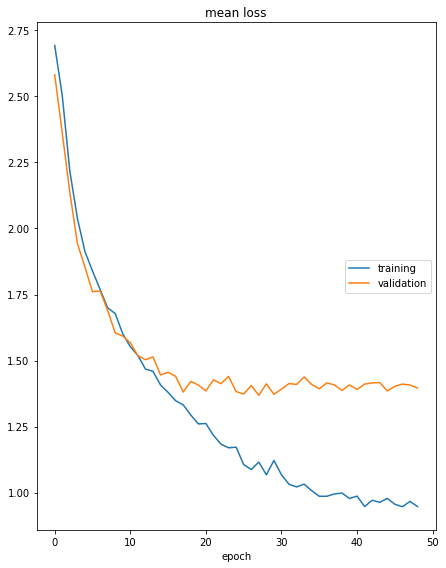

mean loss
	training         	 (min:    0.947, max:    2.693, cur:    0.947)
	validation       	 (min:    1.368, max:    2.582, cur:    1.396)
The model has not improved over the last 20 epochs, stop training


In [63]:
lr_scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.9)

best_val_loss, best_model = train_eval_loop(model,
                                            train_dataset,
                                            val_dataset,
                                            batch_nllloss,
                                            weights=weights,
                                            lr=5e-4,
                                            epoch_n=1000,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            early_stopping_patience=20,
                                            lr_scheduler_ctor=lr_scheduler,
                                            draw_loss=True,
                                            show_bar=False,
                                            dataloader_workers_n=5)


## Some examples of model work:

In [64]:
size_for_demonstrate = 5
demonstrative_dataset = Subset(val_dataset, indices=range(size_for_demonstrate))
demonstrative_tags_pred = predict_tags(best_model, demonstrative_dataset)

In [67]:
for i in range(size_for_demonstrate):
    (item, _, _), tags = demonstrative_dataset[i]
    test_sentence, _ = test_data[item]

    print('Ground truth:')
    show_markup(test_sentence, tag_converter.indices_to_tags(tags), PALETTE)

    print('Prediction:')
    show_markup(test_sentence, tag_converter.indices_to_tags(demonstrative_tags_pred[i]), PALETTE)
    
    print()

Ground truth:


Prediction:



Ground truth:


Prediction:



Ground truth:


Prediction:



Ground truth:


Prediction:



Ground truth:


Prediction:


## Prediction and confusion matrix:

In [68]:
val_tags_pred = predict_tags(best_model, val_dataset, device=None, batch_size=662)

In [69]:
y_pred, y_true = [], []

for i in range(len(val_dataset)):
    (_, _, sentence_len), tags = val_dataset[i]
    y_pred += tag_converter.indices_to_tags(val_tags_pred[i])
    y_true += tag_converter.indices_to_tags(tags[:sentence_len])

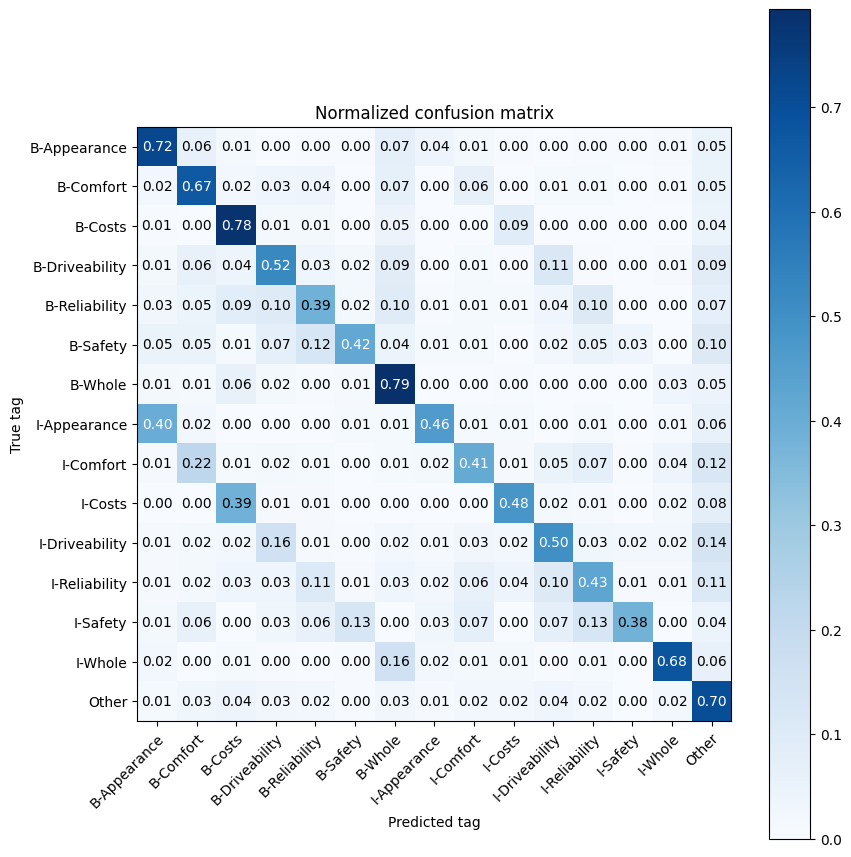

In [75]:
plot_confusion_matrix(y_true, y_pred, classes=tag_converter.idx_to_tag, figsize=(9,9), normalize=True, 
                      title='Normalized confusion matrix')

plt.show()